In [1]:
import sys
sys.path.append('src')
from dataset import MatterSimEnv

grid_pano = False

if grid_pano:
    # mattersimenv = MatterSimEnv(render=True, img_size=(24, 480), vfov=120, discrete_view=False)
    mattersimenv = MatterSimEnv(render=True, img_size=(64, 64), vfov=60, discrete_view=True)
else:
    # mattersimenv = MatterSimEnv(render=True, img_size=(50, 480), vfov=80, discrete_view=False)
    mattersimenv = MatterSimEnv(render=True, img_size=(50, 572), vfov=90, discrete_view=False)

# it seems that there are some bugs in the MatterSim
# when re-creating a MatterSimEnv Object, it will not render at all

from dataset import R2R
dataset = R2R(split='val_unseen')

In [2]:
from model import PRET
from agent import AgentPath as Agent
from config import device


class config:
    text_backbone = 'ALBEF'
    dataset = 'R2R'
    dropout = 0
    hidden_dim = 768
    nhead = 12
    OPE_layer_num = 2
    MAM_layer_num = 4
    CCM_layer_num = 1

    max_step = 15
    loss_weight = 0.2
    mask_visited = True
    use_panorama = True
    use_directed = True

model = PRET(config)
agent = Agent(config, model)

path = 'log/commit/2024-03-01_15:03:33_R2R,MLM,CLIP'
agent.load(path)
agent.to(device)
agent.eval()
print()

Loading ALBEF...
model.pt loaded



In [3]:
import cv2
import math
import types
import numpy as np
import pandas as pd
from utils import to_numpy
import torch.nn.functional as F

F.multi_head_attention_forward
# Hook the attention of transformer decoder
# to get the attention weight, replace the method of nn.TransformerDecoderLayer is required
text_cross = []
pano_cross = []
def text_cross(self, x, mem, attn_mask, key_padding_mask):
    x, attn = self.multihead_attn(x, mem, mem,
                        attn_mask=attn_mask,
                        key_padding_mask=key_padding_mask,
                        need_weights=True,
                        average_attn_weights=False)
    attn.retain_grad()
    text_cross.append(attn)
    return self.dropout1(x)

def pano_cross(self, x, mem, attn_mask, key_padding_mask):
    x, attn = self.multihead_attn(x, mem, mem,
                            attn_mask=attn_mask,
                            key_padding_mask=key_padding_mask,
                            need_weights=True,
                            average_attn_weights=False)
    # You need to remove "attn_output_weights.view(bsz, num_heads, tgt_len, src_len)"
    # in F.multi_head_attention_forward
    # other wise you can only retain the grad of the viewed attention weights, which
    # will not get the gradient.
    attn.retain_grad()
    pano_cross.append(attn)
    return self.dropout2(x)


for layer in agent.model.MAM.layers:
    layer._mha_block = types.MethodType(text_cross, layer)
for layer in agent.model.OPE.layers:
    layer._mha_block = types.MethodType(pano_cross, layer)


# add backward for each action
np.set_printoptions(precision=4, suppress=True)
def new_take_action(self, obs):
    """
    make low-level action according to make high-level action.
    """
    assert not self.training
    if self.batch_path is None:
        self.step += 1

        probs, unvisited = self._take_action(obs)
        
        print(probs[0].detach().cpu().numpy().round(4))
        probs[0, probs.argmax(dim=1)[0]].backward(retain_graph=True)  # add backward
        
        self.batch_path = self._get_path(obs, probs.argmax(dim=1).tolist(), unvisited)
        self.batch_path = pd.DataFrame(self.batch_path)
        
        print(self.batch_path.iloc[0].tolist())
        
        self.local_step = 1

    # defulat action is STOP
    local_actions = np.zeros(len(obs), dtype=np.int64)
    if self.batch_path.shape[1] > 1:
        for i in range(obs.shape[0]):
            if self.stopped[i]:
                continue
            next_viewpoint_id = self.batch_path.at[i, self.local_step]
            local_actions[i] = self._get_local_selection(obs.at[i, 'candidates'], next_viewpoint_id)

        stop_at_this_step = self.batch_path.iloc[:, 1].isna().to_numpy()
        self.stopped |= stop_at_this_step
        temporary_stop = (local_actions == 0) & ~self.stopped
        local_actions[temporary_stop] = -1

    # global action结束
    self.local_step += 1
    if self.local_step >= self.batch_path.shape[1]:
        self.batch_path = None

    return local_actions
agent.take_action = types.MethodType(new_take_action, agent)

# navigate of a sample.
data = dict()
dataloader = dataset.get_batches(batch_size=1)

In [4]:
def get_panorama(obs):
    current_heading = obs.at[0, 'heading']
    candidates = obs['candidates'][0]

    panorama = []
    for up in [30, 0, -30]:
        pano = []
        for i in range(12):
            mattersimenv.new_episode(obs.at[0, 'scan_id'], obs.at[0, 'viewpoint_id'], current_heading - math.pi + np.radians(i * 30), np.radians(up))
            state = mattersimenv.get_state()
            img = to_numpy(state.rgb) / 255
            h, w, c = img.shape
            pad = h // 20
            if state.viewIndex in candidates['view_index'].tolist():
                img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), constant_values=255.0)
                x = w//2
                y = h//2
                for idx in candidates.index[candidates['view_index'] == state.viewIndex]:
                    # NOTE: get the index from local_viewpoint_ids rather than candidates
                    cv2.putText(img, f'{idx + 1}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255.0, 0, 0), 2)
            else:
                img = np.pad(img, ((pad, pad), (pad, pad), (0, 0)))
            pano.append(img)
        pano = np.concatenate(pano, axis=1)
        panorama.append(pano)
    panorama = np.concatenate(panorama, axis=0)
    return panorama

In [5]:
path = []
dataloader = [dataset[[3]]]
for batch, env in dataloader:
    obs = env.reset()
    agent.reset(batch)

    data['text_tokens'] = agent.model.tokens
    
    step = 0
    while step < 15:
        path.append(obs.at[0, 'viewpoint_id'])

        # forward
        text_cross = []
        pano_cross = []
        QFormer_attn = []
        agent.zero_grad(set_to_none=True)
        actions = agent.take_action(obs)

        if len(text_cross) > 0:
            step += 1
            
            data[f'text_attn_{step}'] = text_cross
            data[f'pano_attn_{step}'] = pano_cross

            # vision tokens
            data[f'vision_tokens_{step}'] = ['cls']
            token_num = text_cross[0].shape[-2]
            local_num = len(agent.graph.to_be_updated)
            prefix_num = token_num - 1 - local_num
            data[f'vision_tokens_{step}'] += [f'prefix{i+1}' for i in range(prefix_num)]
            data[f'vision_tokens_{step}'] += [f'local{i}' for i in range(local_num)]

            scan_id = obs.at[0, 'scan_id']
            viewpoint_id = obs.at[0, 'viewpoint_id']
            current_heading = obs.at[0, 'heading']
            print(obs.at[0, 'candidates']['view_index'].tolist())
            if grid_pano:
                panorama = get_panorama(obs)
            else:
                img_size = (50, 480)
                vfov = 2 * np.arctan(img_size[1] / img_size[0] * np.tan(np.radians(5))) * 180 / np.pi  # about 80
                imgs = []
                for i in range(36):
                    mattersimenv.new_episode(scan_id, viewpoint_id, current_heading - np.radians(180) + np.radians(10) * i, 0)
                    rgb = mattersimenv.get_state().rgb
                    rgb = np.array(rgb)
                    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) / 255
                    imgs.append(rgb)
                panorama = np.concatenate(imgs, axis=1)
            data[f'panorama_{step}'] = panorama
            data[f'heading_{step}'] = current_heading
        
        # print information
        print(f'step {step}:', actions[0], obs.at[0, 'teacher_selection'], obs.at[0, 'distance_to_goal'])
        print()
        if actions[0] == 0:
            break
        obs = env.step_viewpoint(obs, actions)
    break

print(batch.at[0, 'scan'])
print(batch.at[0, 'instruction'])
print(batch.at[0, 'index'])
"""

"""

Loading ./data/img_features/ViT-patch16-224-CLIP.pkl
Loading ./data/candidate_buffer.pkl
[0.0003 0.0312 0.4895 0.4785 0.0005]
['faed19f97550433b958958f4df869251', '2b519d8eee9c4abb88444a397e87cd6f']
[15, 17, 18, 22]
step 1: 2 3 8.037513542415756

[0.0005 0.0093 0.7471 0.0007 0.0116 0.0505 0.1802]
['2b519d8eee9c4abb88444a397e87cd6f', 'faed19f97550433b958958f4df869251', '659c84430ca14aa5bf83a61683649a89']
[12, 12, 23, 18, 18]
step 2: 3 2 9.645321146644456

step 2: 3 3 8.037513542415756

[0.     0.0001 0.     0.0002 0.0002 0.0005 0.9989]
['659c84430ca14aa5bf83a61683649a89', '5b2de972faea4ca381cd72140f77b0c0']
[12, 23, 14, 15, 30]
step 3: 5 5 6.7074488021117356

[0.     0.0001 0.0001 0.     0.0001 0.0001 0.9996]
['5b2de972faea4ca381cd72140f77b0c0', '930cbd6da8f14dfba4d883c55a069f96']
[0, 23, 13, 30]
step 4: 4 4 5.33927342238149

[0.0002 0.0001 0.0001 0.0001 0.0001 0.0002 0.9993]
['930cbd6da8f14dfba4d883c55a069f96', '2c9141f7b24547c3808608bf9ad54b4d']
[0, 30]
step 5: 2 2 3.6937247811070977


'\n\n'

['faed19f97550433b958958f4df869251', '2b519d8eee9c4abb88444a397e87cd6f', 'faed19f97550433b958958f4df869251', '659c84430ca14aa5bf83a61683649a89', '5b2de972faea4ca381cd72140f77b0c0', '930cbd6da8f14dfba4d883c55a069f96', '2c9141f7b24547c3808608bf9ad54b4d', 'ec0a7a6c66244eeea1fba43caddae01a']
['faed19f97550433b958958f4df869251', '659c84430ca14aa5bf83a61683649a89', '5b2de972faea4ca381cd72140f77b0c0', '930cbd6da8f14dfba4d883c55a069f96', '2c9141f7b24547c3808608bf9ad54b4d', 'ec0a7a6c66244eeea1fba43caddae01a']


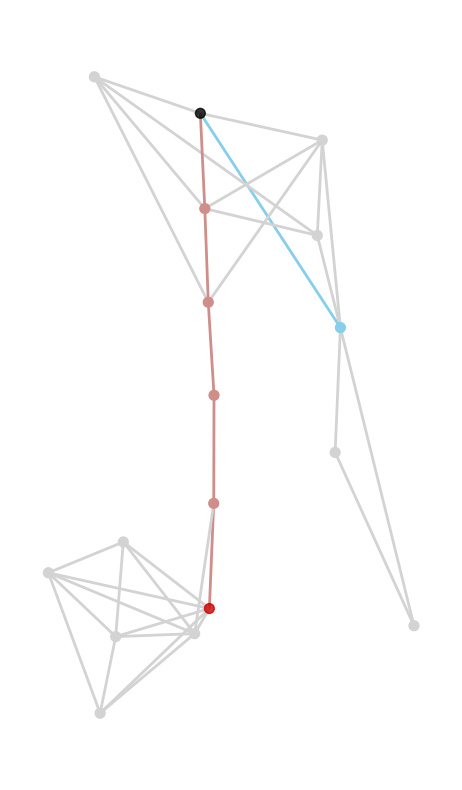

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array

from src.utils import load_graph


def edge_in_path_(u, v, path):
    for i in range(len(path) - 1):
        if path[i:i+2] == [u, v]:
            return True
        if path[i:i+2] == [v, u]:
            return True
    return False


def plot_graph(scan, path, gt_path):
    graph = load_graph(scan)
    
    nodelist = set()
    for node in set(path + gt_path):
        nodelist.add(node)
        for neighbor in graph.neighbors(node):
            nodelist.add(neighbor)
    nodelist = list(nodelist)
    
    subgraph = graph.subgraph(nodelist)

    fig, ax=plt.subplots(figsize=(10, 10))
    pos = dict()
    node_color = []
    alpha = 1
    skyblue = to_rgba_array('skyblue', alpha)
    tomato = to_rgba_array('tomato', alpha)
    gray = to_rgba_array('lightgray')
    for node in nodelist:
        pos[node] = graph.nodes[node]['pos3d'][:2]
        
        if node in path and node in gt_path:
            mix_weight = 0.4
            color = mix_weight * skyblue + (1 - mix_weight) * tomato
        elif node in path:
            color = skyblue
            if node == path[-1]:
                color = to_rgba_array('blue', alpha)
        elif node in gt_path:
            color = tomato
        else:
            color = gray

        if node == gt_path[0]:
            color = to_rgba_array('black') * 0.8
        elif node == gt_path[-1]:
            color = to_rgba_array('red') * 0.8
        
        node_color.append(color)

    edge_color = []
    for u, v in subgraph.edges:
        edge_in_path = edge_in_path_(u, v, path)
        edge_in_gt_path = edge_in_path_(u, v, gt_path)
        if edge_in_path and edge_in_gt_path:
            color = mix_weight * skyblue + (1 - mix_weight) * tomato
        elif edge_in_path:
            color = skyblue
        elif edge_in_gt_path:
            color = tomato
        else:
            color = gray

        edge_color.append(color)

    nx.draw_networkx(subgraph, pos,
        with_labels=False, node_size=50, width=2,
        nodelist=nodelist, node_color=node_color, edge_color=edge_color,
        ax=ax,
    )
    plt.axis('off')
    plt.gca().set_aspect('equal')
    # plt.savefig('graph.svg')
    plt.show()


print(path)
print(batch.at[0, 'path'])
plot_graph(obs.at[0, 'scan_id'], path, batch.at[0, 'path'])

In [7]:
"""
Visualize Decoder Attention.
"""
from bertviz import head_view
step = 3

# import torch.nn.functional as F
F.multi_head_attention_forward
def get_gradcam(attn, use_grad=True):
    cam = attn.view(-1, 12, attn.shape[1], attn.shape[2])
    
    if use_grad:
        grad = attn.grad.view(-1, 12, attn.shape[1], attn.shape[2])
        gradcam = grad.clip(0) * cam
    else:
        gradcam = cam
    
    gradcam = gradcam.sum(dim=1, keepdim=True)
    return gradcam


text_cross = [get_gradcam(attn) for attn in data[f'text_attn_{step}']]
pano_cross = [get_gradcam(attn, use_grad=False) for attn in data[f'pano_attn_{step}']]


# normalize to visualize
max_gradcam = max([attn.max() for attn in text_cross])
text_cross = [attn / max_gradcam for attn in text_cross]

max_gradcam = max([attn.max() for attn in pano_cross])
pano_cross = [attn / max_gradcam for attn in pano_cross]


head_view(
    cross_attention=text_cross,
    encoder_tokens=data['text_tokens'],
    decoder_tokens=data[f'vision_tokens_{step}'],
)

<IPython.core.display.Javascript object>

[101, 2735, 2157, 1998, 2175, 2039, 1996, 5108, 1998, 3233, 2012, 1996, 2327, 1012, 102]


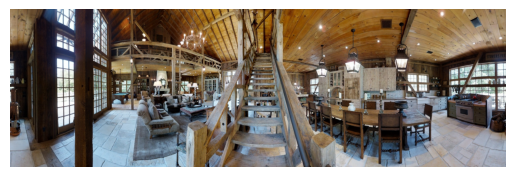

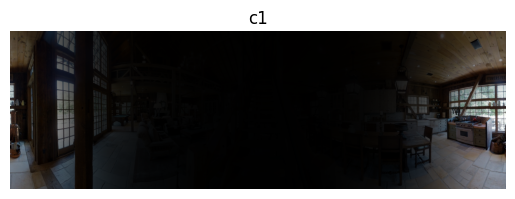

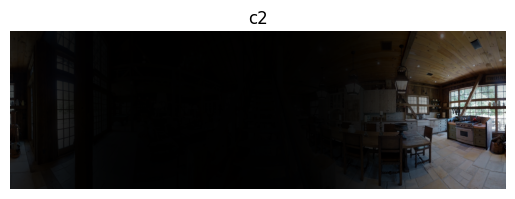

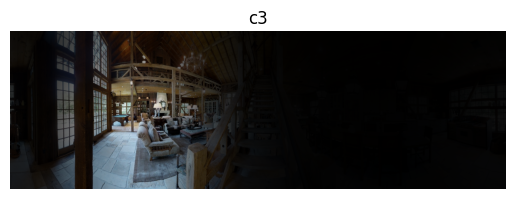

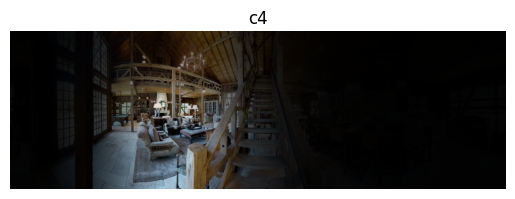

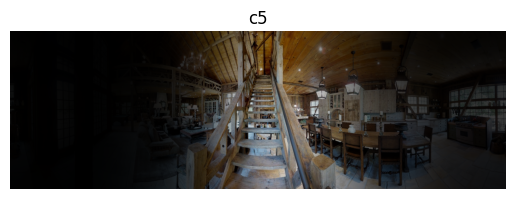

In [8]:
import cv2
import matplotlib.pyplot as plt
print(batch.at[0, 'instruction'])


def normalize(img):
    img -= img.min()
    max_value = img.max()
    assert max_value > 0, 'img are all zero'
    return img / max_value


def mix_image_mask(img, attention_mask, blur=True):
    if blur:
        sigma = 0.05 *  max(img.shape[0:])
        attention_mask = cv2.GaussianBlur(attention_mask, ksize=(0, 0), sigmaX=sigma)
        attention_mask = normalize(attention_mask)  # scale the mask to make it look clearer
    
    # map to jet
    # cmap = plt.get_cmap('gray')
    # heatmap = cmap(attention_mask)
    # heatmap = np.delete(heatmap, 3, 2)  # from RGBA to RGB
    heatmap = attention_mask[:, :, None] + 0.01

    # mix
    # alpha = (attention_mask ** 0.7)[:, :, None]
    # attention_mask = (1 - alpha) * img + alpha * heatmap
    attention_mask = img * heatmap

    # due to the numeric error, we need to clip the image into [0, 1]
    attention_mask = np.clip(attention_mask, a_min=0, a_max=1)
    return attention_mask


layer = 1

attn = pano_cross[layer]
panorama = data[f'panorama_{step}']
assert data[f'heading_{step}'] >= 0
shift = panorama.shape[1] * (0.5 - data[f'heading_{step}'] / (2 * math.pi))
shift_matrix = np.array([[1, 0, float(shift)], [0, 1, 0]])

plt.figure()
plt.imshow(panorama)
plt.axis('off')

for c in range(attn.shape[2]):
    plt.figure()
    attention_mask = attn[0, 0, c, :].detach().cpu().numpy()
    attention_mask = attention_mask.reshape(3, 12)[::-1, :]
    attention_mask = normalize(attention_mask)
    attention_mask = cv2.resize(attention_mask, panorama.shape[1::-1], interpolation=cv2.INTER_NEAREST)
    attention_mask = cv2.warpAffine(attention_mask, shift_matrix, attention_mask.shape[::-1], borderMode=cv2.BORDER_WRAP)

    img = mix_image_mask(panorama, attention_mask, blur=True)
    plt.title(f'c{c+1}')
    plt.imshow(img)
    plt.axis('off')
